# Data loading

We start by importing the packages and data.

In [1]:
%matplotlib inline
import scanpy.preprocessing
import scanpy.plotting
import scanpy.tools
import matplotlib.pyplot as plt
import pandas
import numpy

adata = scanpy.read_h5ad("../../Data/treatments_data.h5ad")

We get the conditions of each organoid, and add a treatment/celltype category:

In [15]:
adata.obs["treatment"] = pandas.Categorical([organoid.split("-")[0] for organoid in adata.obs.organoid])

We make a quick heatmap to check whether the data looks sensible:

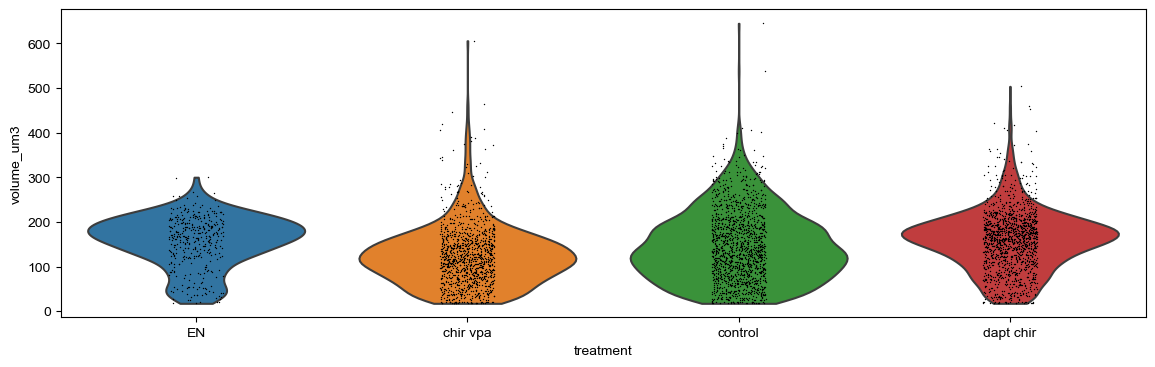

In [3]:
figure = plt.figure(figsize=(14, 4))
ax = figure.gca()
scanpy.plotting.violin(adata,
                       ax=ax,
                       keys=["volume_um3"], 
                       groupby="treatment")

# Start of analysis

Now we normalize the data:

In [4]:
scanpy.preprocessing.log1p(adata)
scanpy.preprocessing.scale(adata)

We also define a cell type palette that we will use everywhere:

In [5]:
cell_type_palette = {
    "ENTEROCYTE": "#100069",
    "OTHER_DIFFERENTIATED": "#100069",
    "ABSORPTIVE_PROGENY": "#0984e3",
    "SECRETORY": "#74b9ff",
    "ENTEROENDOCRINE": "#74b9ff",
    "GOBLET": "#74b9ff",
    "MATURE_GOBLET": "#74b9ff",
    "SECRETIVE_PROGENY": "#74b9ff",
    "WGA_PLUS": "#74b9ff",
    "OTHER_SECETORY": "#74b9ff",
    "PANETH": "#B60101",
    "STEM": "#26CC3C",
    "STEM_PUTATIVE": "#26CC3C",
    "UNLABELED": "#eeeeee",
    "TA": "#eeeeee",
    "NONE": "#ffffff"
}

Next, we plot the highly variable "genes" (or actually, nucleus parameters.)

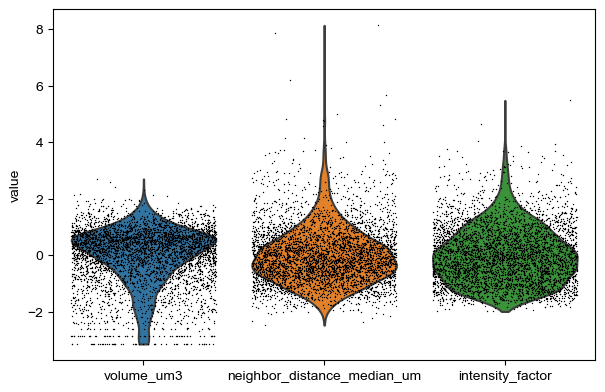

In [6]:

scanpy.plotting.violin(adata, ['volume_um3', 'neighbor_distance_median_um', 'intensity_factor'],
             jitter=0.4)


Next, we perform and plot the PCA:

d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'cell_type_training'}, xlabel='PC3 (10.14%)', ylabel='PC4 (8.96%)'>

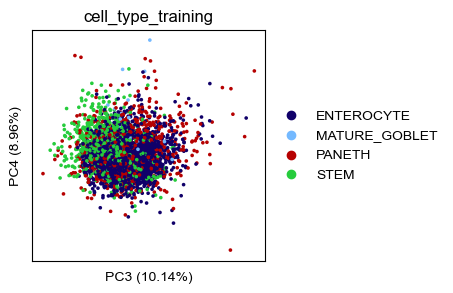

In [7]:
scanpy.tools.pca(adata, svd_solver='arpack')
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.pca(adata, ax=fig.gca(), annotate_var_explained=True, color="cell_type_training", palette=cell_type_palette, show=False,
                    dimensions=[(2,3)])

And show the elbow plot:

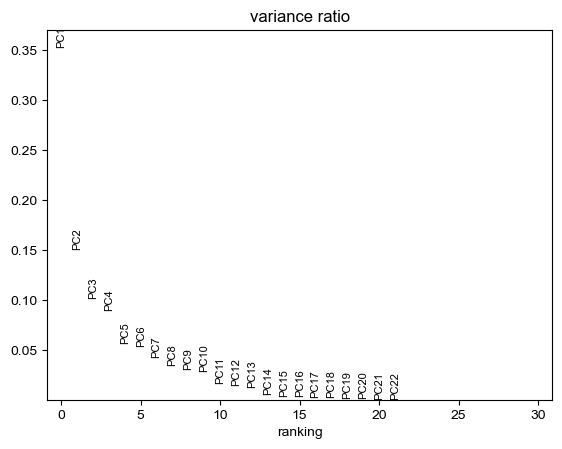

In [8]:
scanpy.plotting.pca_variance_ratio(adata, log=False)

d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


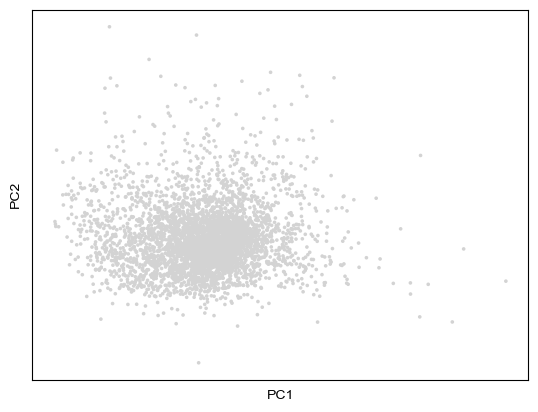

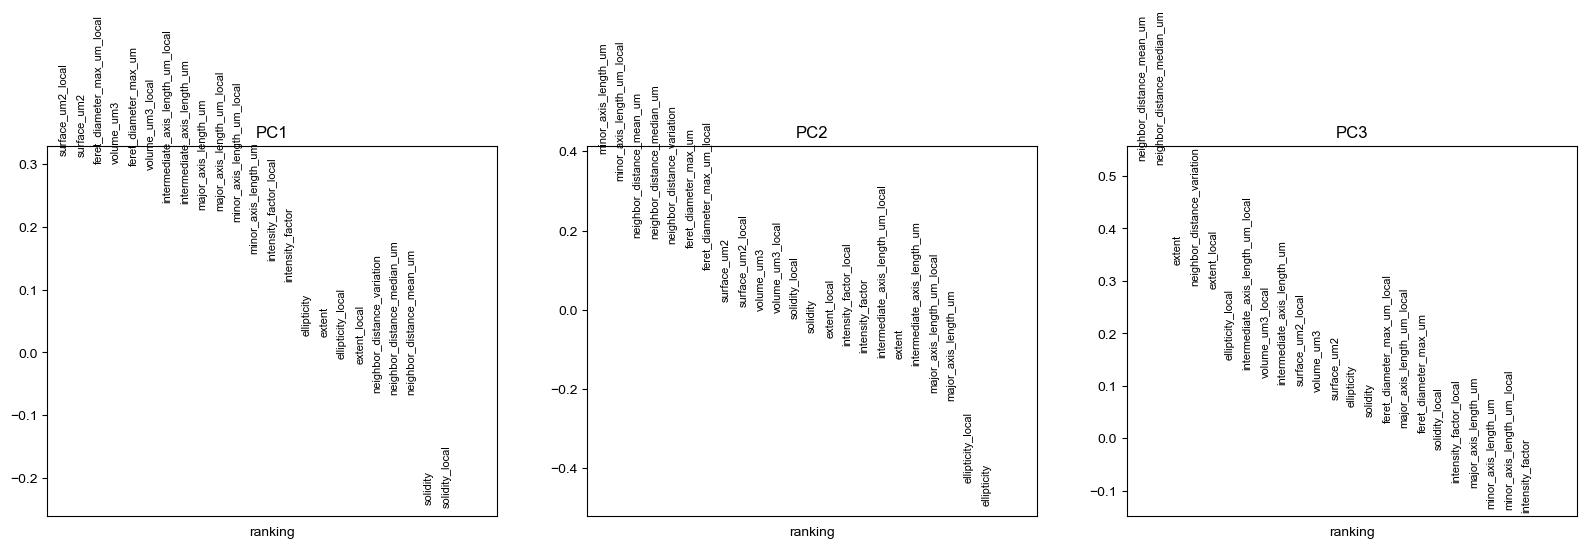

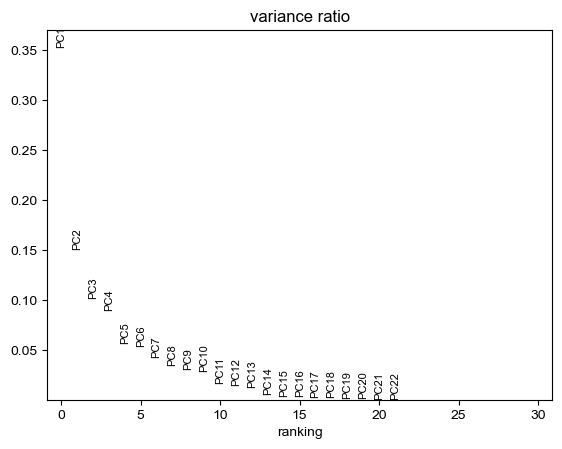

In [9]:
scanpy.plotting.pca_overview(adata)

# UMAP clustering
Do UMAP clustering:

In [10]:
scanpy.preprocessing.neighbors(adata, n_pcs=10)
scanpy.tools.umap(adata)


And make some plots out of it:

d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


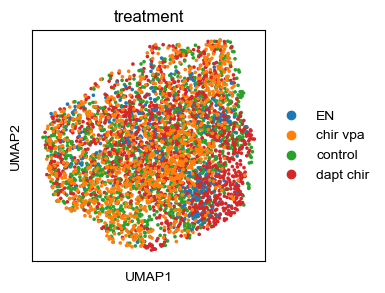

In [11]:
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.umap(adata, color="treatment", ax=fig.gca())

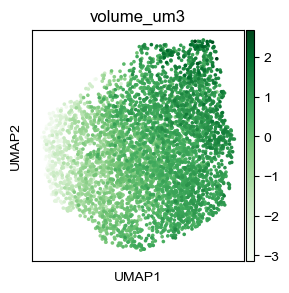

In [12]:
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.umap(adata, color="volume_um3", color_map="Greens", ax=fig.gca())

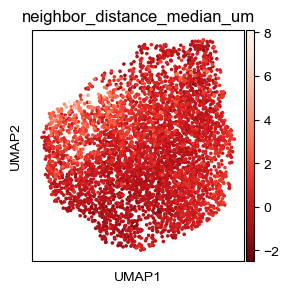

In [13]:
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.umap(adata, color="neighbor_distance_median_um", color_map="Reds_r", ax=fig.gca())

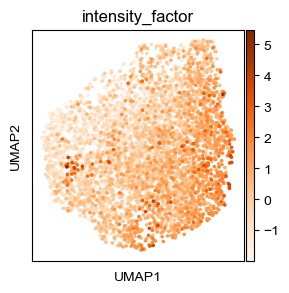

In [14]:
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.umap(adata, color="intensity_factor", color_map="Oranges", ax=fig.gca())

# Most important variables for each cell type

d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\plotting\_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


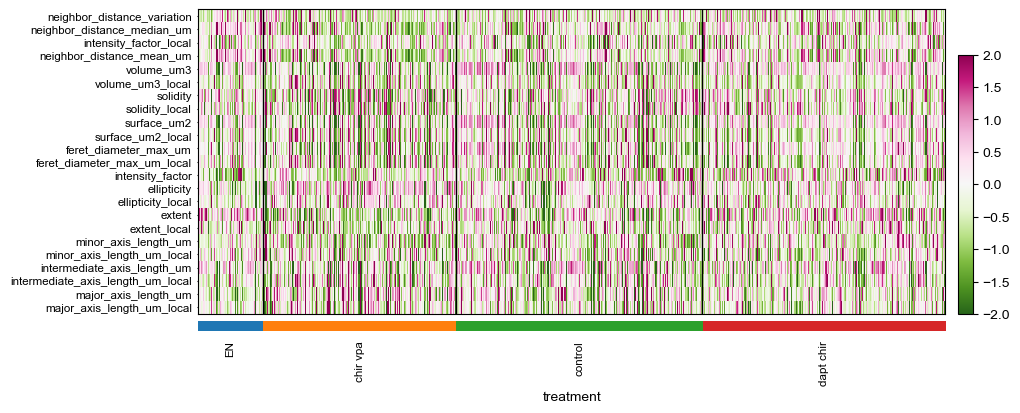

In [19]:
scanpy.plotting.heatmap(adata,
                        var_names=adata.var_names, 
                        groupby="treatment", 
                        cmap="PiYG_r", 
                        swap_axes=True, 
                        vmin=-2,
                        vmax=2,
                        save="heatmap.svg")


d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


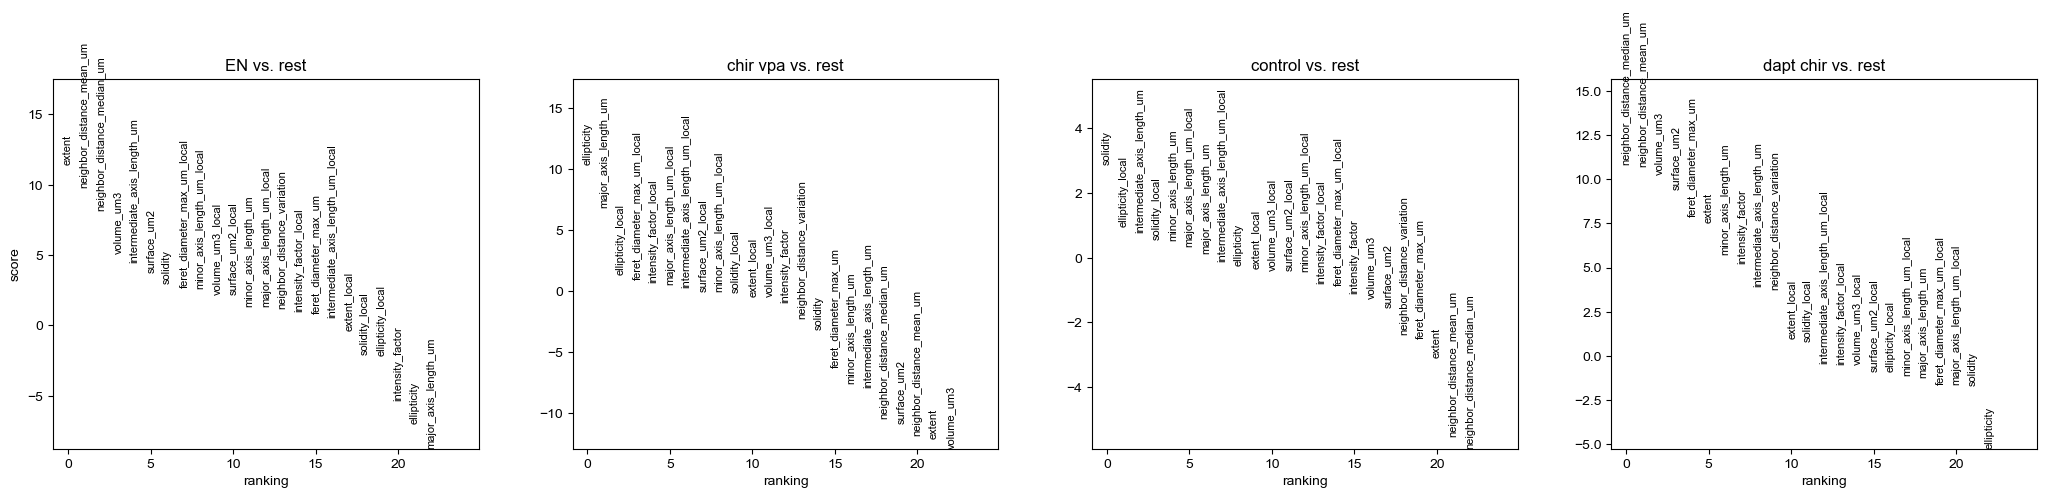

In [16]:
scanpy.tools.rank_genes_groups(adata, 'treatment', method='wilcoxon')
scanpy.plotting.rank_genes_groups(adata, n_genes=25, sharey=False)

In [17]:
var_name = adata.uns["rank_genes_groups"]["names"]
p_value = adata.uns["rank_genes_groups"]["pvals_adj"]


In [22]:
print(var_name[0])  # Most important variables for each treatment

('extent', 'ellipticity', 'solidity', 'neighbor_distance_median_um')


d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\plotting\_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


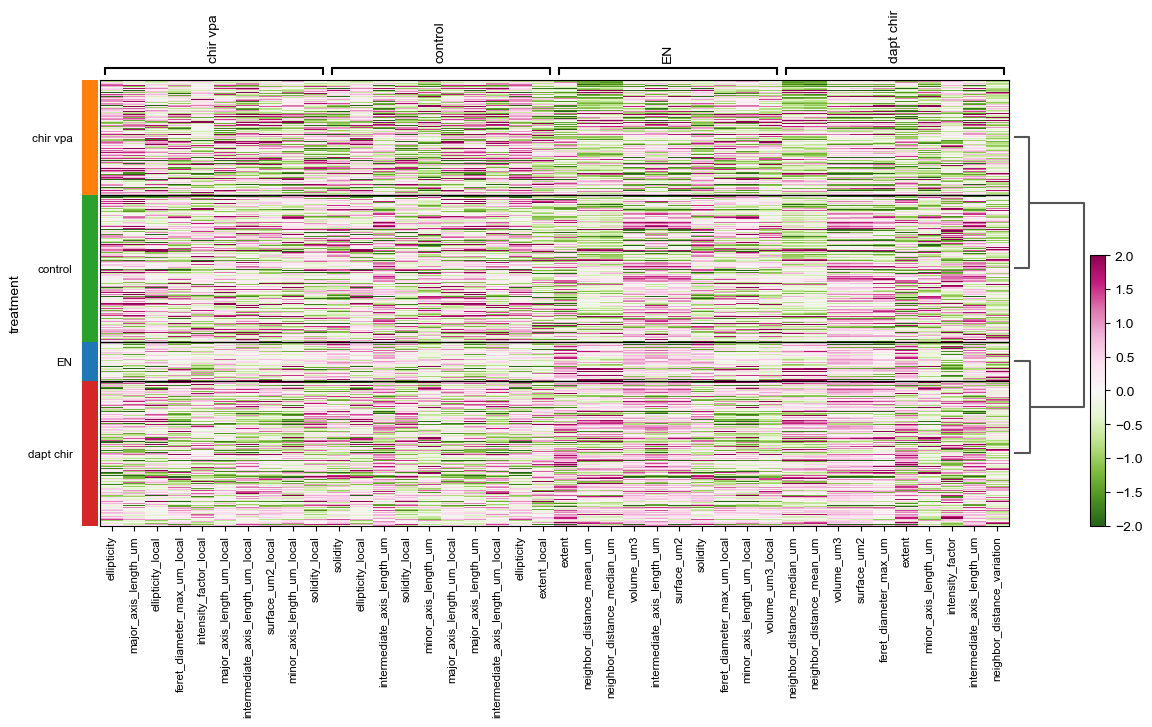

In [56]:
scanpy.plotting.rank_genes_groups_heatmap(adata, vmin=-2, vmax=2, cmap="PiYG_r")

In [129]:
organoid_list = list(adata.obs.organoid.unique())
treatment_list = []
mean_table = numpy.zeros((len(organoid_list), len(adata.var_names)), dtype=numpy.float32)
for i, organoid in enumerate(organoid_list):
    mean_table[i, :] = adata[adata.obs.organoid == organoid].X.mean(axis=0)
    treatment = adata.obs[adata.obs.organoid == organoid].treatment.iloc[0]
    treatment_list.append(treatment)
# Put mean_table in an AnnData object
mean_adata = scanpy.AnnData(X=mean_table)

In [130]:
# Add the gene names to mean_adata from adata and the treatment names
mean_adata.var_names = adata.var_names
mean_adata.obs_names = organoid_list
mean_adata.obs["treatment"] = pandas.Categorical(treatment_list)

In [131]:
# Sort genes by their mean expression for the control treatment
mean_adata = mean_adata[:, mean_adata[mean_adata.obs.treatment == "control"].X.mean(axis=0).argsort()]

d:\miniconda\envs\organoid_tracker\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
d:\miniconda\envs\organoid_tracker\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
d:\miniconda\envs\organoid_tracker\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs

In [17]:
scanpy.plotting.heatmap(mean_adata, var_names=mean_adata.var_names, groupby="treatment-celltype", cmap="PiYG_r", swap_axes=True, vmin=-2, vmax=2, figsize=(3, 4))


NameError: name 'mean_adata' is not defined